In [1]:
# Install the following librairies (it is better to create a venv (or conda) virtual environment first and install these librairies in it)
!pip install mlflow
!pip install --upgrade jinja2
!pip install --upgrade Flask
!pip install setuptools

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Explore
- Let's quick load and explore to see which one should be the best suitable for this project and for the constraint of available resources, including time, cpu, gpu

In [2]:
from  google.colab import files
uploaded = files.upload()


Saving Loan_Data.csv to Loan_Data.csv


In [3]:
# Get dataset paths
df_path = 'Loan_Data.csv'


In [4]:
import pandas as pd

# Load datasets
df = pd.read_csv(df_path)


In [5]:
 # Show some sample of each df
df.head(3)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0


In [6]:
# print info of each df
print('Dataset #1 Info: \n')
print(df.info())



Dataset #1 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB
None


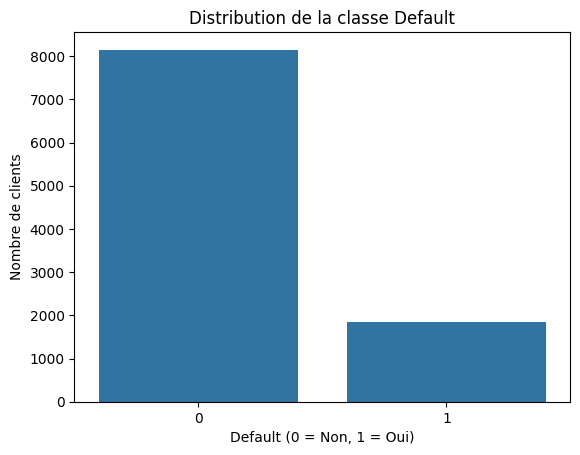

In [7]:
# Compter les occurrences de chaque classe de défaut
default_counts = df['default'].value_counts()

# Bar plot
sns.barplot(x=default_counts.index, y=default_counts.values)
plt.title('Distribution de la classe Default')
plt.xlabel('Default (0 = Non, 1 = Oui)')
plt.ylabel('Nombre de clients')
plt.show()


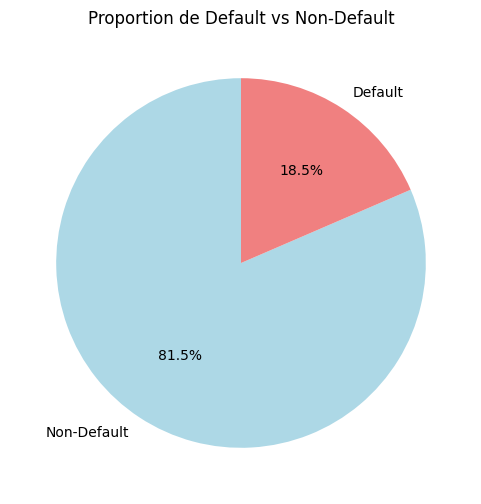

In [8]:
# Pie chart pour la classe default
plt.figure(figsize=(6,6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Proportion de Default vs Non-Default')
plt.show()


In [9]:
# Calculer le nombre de valeurs nulles par colonne
valeurs_nulles = df.isnull().sum()

# Afficher le résultat
print(valeurs_nulles)


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


# 2. Modeling a sentiment classifier
- The objective is to
    - Load the chosen dataset
    -  Selecting main features for modeling sentiment classifier
    -  Cleaning Tweet texts
    -  Balancing the dataset by sentiment class
    -  Split the dataset into train, validation and test subsets
    -  Train two sentiment classifiers
        - One for base ML method: Logistic Regression
        - One for advanced DL method: fine-tuning BERT model
    - Inference
    - Calculate the metrics
    - Comparing the performance of different models


In [10]:
# Count the sentiment labels by class
df['default'].value_counts().sort_values(ascending=False)

,count
default,
0,8149
1,1851


In [11]:
# Supprimer la colonne customer_id car elle n'est pas pertinente pour la modélisation
X = df.drop('customer_id', axis=1)
y = df['default']

In [29]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Étape 3: Model Engineering

# 1. Régression Logistique
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [32]:
# Prédictions et évaluation
y_pred_logreg = logreg.predict(X_test_scaled)
print("Régression Logistique - Classification Report")
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))



Régression Logistique - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      1.00      1.00       348

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 1.0
Confusion Matrix:
[[1652    0]
 [   0  348]]


In [33]:
# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Prédictions et évaluation
y_pred_rf = rf.predict(X_test_scaled)
print("\nRandom Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))



Random Forest - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      1.00      1.00       348

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 1.0


In [39]:
with mlflow.start_run():

    # Étape 3: Model Engineering

    # 1. Régression Logistique
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)

    # Prédictions et évaluation
    y_pred_logreg = logreg.predict(X_test_scaled)
    roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

    # Enregistrer les métriques avec MLflow
    mlflow.log_metric("accuracy_logreg", logreg.score(X_test_scaled, y_test))
    mlflow.log_metric("roc_auc_logreg", roc_auc_logreg)

    # Enregistrer le modèle de régression logistique
    mlflow.sklearn.log_model(logreg, "logistic_regression_model")

    # 2. Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Prédictions et évaluation
    y_pred_rf = rf.predict(X_test_scaled)
    roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])

    # Enregistrer les métriques avec MLflow
    mlflow.log_metric("accuracy_rf", rf.score(X_test_scaled, y_test))
    mlflow.log_metric("roc_auc_rf", roc_auc_rf)

    # Enregistrer le modèle Random Forest
    mlflow.sklearn.log_model(rf, "random_forest_model")

    # Capture des métriques pour le rapport
    print("\nRégression Logistique - ROC AUC Score:", roc_auc_logreg)
    print("\nRandom Forest - ROC AUC Score:", roc_auc_rf)

# Terminer l'expérience MLflow
mlflow.end_run()

2024/09/10 22:04:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/10 22:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Régression Logistique - ROC AUC Score: 1.0

Random Forest - ROC AUC Score: 1.0


In [36]:
!pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149

In [ ]:
import re
import emoji

# Function to remove hyperlinks, emojis, hashtags, mentions, emoticons, and HTML entities
def clean_tweet(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove mentions and hashtags
    text = re.sub(r'[@#]\w+', '', text)
    # Remove emoticons
    text = re.sub(r'[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]', '', text)
    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)
    return text

# Apply the function to the tweet column
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Display the DataFrame
df[['text', 'cleaned_text']].head()

C:\Users\easyb\AppData\Local\Temp\ipykernel_16828\1679151588.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['text'].apply(clean_tweet)


,text,cleaned_text
0,@VirginAmerica What @dhepburn said.,What said.
1,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experien...
2,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take an...
3,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""en..."
4,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it


In [ ]:
# Recheck the cleaned text
for t in df["cleaned_text"][0:50]:
    print(t)

 What  said.
 plus you've added commercials to the experience... tacky.
 I didn't today... Must mean I need to take another trip!
 it's really aggressive to blast obnoxious "entertainment" in your guests' faces  they have little recourse
 and it's a really big bad thing about it
 seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
 yes, nearly every time I fly VX this “ear worm” won’t go away 
 Really missed a prime opportunity for Men Without Hats parody, there. 
 Well, I didn't…but NOW I DO! 
 it was amazing, and arrived an hour early. You're too good to me.
 did you know that suicide is the second leading cause of death among teens 10-24
 I 3 pretty graphics. so much better than minimal iconography. 
 This is such a great deal! Already thinking about my 2nd trip to   I haven't even gone on my 1st trip yet! 
  I'm flying your   skies again! U take all the  away from travel 
 Thanks!
 SFO-PDX schedule is still MIA.
 

- **Remarks**: It can be seen that the new feature 'cleaned_text' has sufficient clean texts for the modeling step.

## Create balanced dataset for modeling
- *Remind that* the raw dataset has
    - negative:    9178 samples
    - neutral:     3099 samples
    - positive:    2363 samples
- In this project, I choose downsampling approach to obtain the balanced dataset by choosing the cut-off sampling as the minimum class size (meaning 2363 of positive class). This way, we still has reasonable number of sampling for modeling with machine learning and deep learning approaches.

In [ ]:
# Separate the dataset by sentiment
negative = df[df['airline_sentiment'] == 'negative']
neutral = df[df['airline_sentiment'] == 'neutral']
positive = df[df['airline_sentiment'] == 'positive']

# Determine the minimum class size
min_size = min(len(negative), len(neutral), len(positive))

# Balance the dataset by undersampling
negative_balanced = negative.sample(min_size, random_state=42)
neutral_balanced = neutral.sample(min_size, random_state=42)
positive_balanced = positive.sample(min_size, random_state=42)

# Combine the balanced datasets
balanced_df = pd.concat([negative_balanced, neutral_balanced, positive_balanced])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Let's recheck whether the new dataframe is really balanced
balanced_df['airline_sentiment'].value_counts().sort_values(ascending=False)

airline_sentiment
neutral     2363
positive    2363
negative    2363
Name: count, dtype: int64

- **Remarks**: Well, we really obtained a new balance dataset for the modeling step

## Split dataset into Train, Validation and Test subsets
- This step is important in modeling
    - For Training: we will use Train subset (and Validation subset if applicable)
    - For Testing: we will use Test subset
- We will use 'stratify=balanced_df['airline_sentiment']' to make sure that all the subsets are sampled equally regarding the sentiment classes
- At the end, we will save all subsets into new csv file for later use

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['airline_sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['airline_sentiment'])

# Print the sizes of the datasets
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Save the datasets to CSV files
train_df.to_csv('./data/sentiment_airline_on_tweets/train_airline_sentiment_dataset.csv', index=False)
val_df.to_csv('./data/sentiment_airline_on_tweets/val_airline_sentiment_dataset.csv', index=False)
test_df.to_csv('./data/sentiment_airline_on_tweets/test_airline_sentiment_dataset.csv', index=False)

Train set size: 4962
Validation set size: 1063
Test set size: 1064


## Modeling
In this stage, I will implement two ML methods to modeling the sentiment classifier
- One is more classic: Logistic Regression
- Other is more advanced: Fine-tune Bert model

### ML #1 Logistic Regression

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_val_tfidf = vectorizer.transform(val_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, train_df['airline_sentiment'])

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(test_df['airline_sentiment'], y_pred)
precision_lr = precision_score(test_df['airline_sentiment'], y_pred, average='weighted')
f1_lr = f1_score(test_df['airline_sentiment'], y_pred, average='weighted')

print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, F1 Score: {f1_lr}")

Logistic Regression - Accuracy: 0.75, Precision: 0.7534922123623737, F1 Score: 0.7507287426614965


### ML #2 BERT Fine-tuning

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np
import pandas as pd

# Define a mapping from sentiment labels to numerical values
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Apply the mapping to the sentiment columns in the DataFrames
train_df['airline_sentiment_id'] = train_df['airline_sentiment'].map(label_mapping)
val_df['airline_sentiment_id'] = val_df['airline_sentiment'].map(label_mapping)
test_df['airline_sentiment_id'] = test_df['airline_sentiment'].map(label_mapping)

# Tokenize the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_tokens = tokenizer(train_df['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
X_val_tokens = tokenizer(val_df['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
X_test_tokens = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Create a custom dataset
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.tokens.items()}, self.labels[idx]

train_dataset = TextDataset(X_train_tokens, torch.tensor(train_df['airline_sentiment_id'].values, dtype=torch.long))
val_dataset = TextDataset(X_val_tokens, torch.tensor(val_df['airline_sentiment_id'].values, dtype=torch.long))
test_dataset = TextDataset(X_test_tokens, torch.tensor(test_df['airline_sentiment_id'].values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        tokens, labels = batch
        tokens = {key: val.to(device) for key, val in tokens.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**tokens, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            tokens, labels = batch
            tokens = {key: val.to(device) for key, val in tokens.items()}
            labels = labels.to(device)

            outputs = model(**tokens, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\easyb\Anaconda3\envs\superprof-gpu\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training
- **Attention**:
    - The training is long and it may need a GPU for accelerating training
    - The trained model can be download here: https://1drv.ms/u/s!ApH9RKcWDsubh9A3JAlhWeA7kvKvWA?e=Sz5G3s
    - After downloading the trained model, you can pass to the next cell to load it and run the reference

In [ ]:
# Train the model and log the metrics
num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        tokens, labels = batch
        tokens = {key: val.to(device) for key, val in tokens.items()}
        labels = labels.to(device)

        outputs = model(**tokens)
        _, predicted = torch.max(outputs.logits, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

accuracy_bert = accuracy_score(y_true, y_pred)
precision_bert = precision_score(y_true, y_pred, average='weighted')
f1_bert = f1_score(y_true, y_pred, average='weighted')

print(f"BERT - Accuracy: {accuracy_bert}, Precision: {precision_bert}, F1 Score: {f1_bert}")

# Save the model
model_save_path = 'fine_tuned_bert_airline_sentiment_model.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\easyb\Anaconda3\envs\superprof-gpu\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\easyb\Anaconda3\envs\superprof-gpu\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/3
Train Loss: 0.6148, Train Accuracy: 0.7561
Validation Loss: 0.5834, Validation Accuracy: 0.7658
Epoch 2/3
Train Loss: 0.3827, Train Accuracy: 0.8599
Validation Loss: 0.5873, Validation Accuracy: 0.7479
Epoch 3/3
Train Loss: 0.2378, Train Accuracy: 0.9196
Validation Loss: 0.6441, Validation Accuracy: 0.7827
BERT - Accuracy: 0.8176691729323309, Precision: 0.8177828281534756, F1 Score: 0.8177184095589666


### Reload fine-tuned BERT model and do inference

In [ ]:
model_save_path = 'fine_tuned_bert_airline_sentiment_model.pt'
# Load the model
model_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model_loaded.load_state_dict(torch.load(model_save_path))
model_loaded.to(device)
print(f"Model loaded from {model_save_path}")

# Evaluate the model on the test set
model_loaded.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        tokens, labels = batch
        tokens = {key: val.to(device) for key, val in tokens.items()}
        labels = labels.to(device)

        outputs = model_loaded(**tokens)
        _, predicted = torch.max(outputs.logits, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

accuracy_bert = accuracy_score(y_true, y_pred)
precision_bert = precision_score(y_true, y_pred, average='weighted')
f1_bert = f1_score(y_true, y_pred, average='weighted')

print(f"BERT - Accuracy: {accuracy_bert}, Precision: {precision_bert}, F1 Score: {f1_bert}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from fine_tuned_bert_airline_sentiment_model.pt


C:\Users\easyb\Anaconda3\envs\superprof-gpu\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


BERT - Accuracy: 0.8176691729323309, Precision: 0.8177828281534756, F1 Score: 0.8177184095589666


## Comparing performence of different modeling methods

In [ ]:
print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, F1 Score: {f1_lr}")
print(f"Fine-tuned BERT - Accuracy: {accuracy_bert}, Precision: {precision_bert}, F1 Score: {f1_bert}")

Logistic Regression - Accuracy: 0.75, Precision: 0.7534922123623737, F1 Score: 0.7507287426614965
Fine-tuned BERT - Accuracy: 0.8176691729323309, Precision: 0.8177828281534756, F1 Score: 0.8177184095589666


## Conclusions
- From the above result, tt can be conclude that
    - Advanced method like fine-tuning BERT has outperformed classical ML methods like Logistic Regression
    - With quite small training subset of 4962 samples, fine-tuned BERT model can obtain more than 80% of accuracy, precision and f1 scores, it is really interesting
- Perspective:
    - We can do better if I can train on larger balanced dataset
      

# 3. Insightful Analytics on sentiment dataset 'sentiment_airline_on_tweets'
- The objective is to
    - Analyze trends in sentiment over time or across different topics.
    - Visualize the results to provide actionable insights.
    - Find correlation between features to drive decision making
- For this purpose, we will work with the raw format of this dataset, including key features: airline_sentiment(14640 non-null), text(14640 non-null), negativereason(9178 non-null), airline(14640 non-null), tweet_created(14640 non-null)

## Load dataset

In [ ]:
import pandas as pd

# Get dataset path
df_path = './data/sentiment_airline_on_tweets/Tweets.csv'

# Load dataset
df = pd.read_csv(df_path)
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


## EDA

In [ ]:
# Get dataset feature name
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
# Get dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- **Remarks**: We can see that 'tweet_created' feature represents the timestamp values but it is saved in the 'object' format. We need to correct this

## What is the time range covered by the dataset?

In [ ]:
# Correct the timestamp format
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

# Find the earliest timestamp
earliest_timestamp = df['tweet_created'].min()

# Find the latest timestamp
latest_timestamp = df['tweet_created'].max()

print(f"Earliest timestamp: {earliest_timestamp}")
print(f"Latest timestamp: {latest_timestamp}")

Earliest timestamp: 2015-02-16 23:36:05-08:00
Latest timestamp: 2015-02-24 11:53:37-08:00


- **Remarks**: We can see that the dataset records the data over **8 days** from 2015-02-16 to 2015-02-24

## How many Airways are involved in the dataset?

In [ ]:
# Count airway companies
df['airline'].value_counts().sort_values(ascending=False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

- **Remarks**: It can be seen that there are **6** airways companies involved in this dataset. United has the greatest number of feedbacks with 3822, more than 7 times that of Virgin America

## What is the distribution of sentiment class for each airway company?

In [ ]:
# Group by 'airline' and 'sentiment' and count the occurrences
sentiment_distribution = df.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)

# Display the DataFrame
print(sentiment_distribution)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


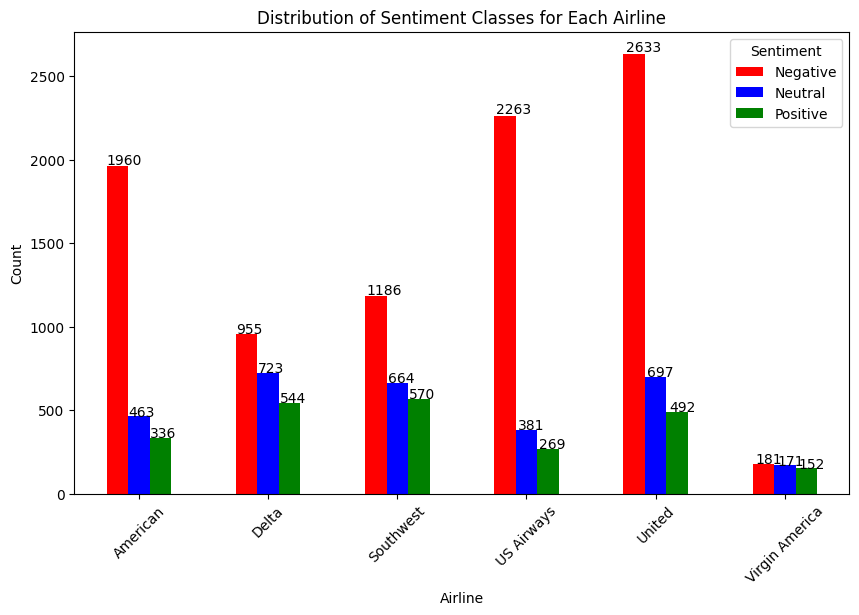

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the bar chart
ax = sentiment_distribution.plot(kind='bar', stacked=False, color=['red', 'blue', 'green'], figsize=(10, 6))

# Adding labels and title
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes for Each Airline')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=45)

# Adding count annotations on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

- **Remarks**:
    - Virgin America has the least samples but the sentiment classes are quite equal, with around 30% each each sentiment class
    - For other airways, the negative Tweets really dominate the positive and neutral groups, especially for United, US Airways and American airways.
    - It can be concluded that the Tweets are mainly used to mention the negative sentiments

## How many samples for each sentiment class?

In [ ]:
# Count sentiment sample for each sentiment class
sentiment_counts = df['airline_sentiment'].value_counts().sort_values(ascending=False)
sentiment_counts

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

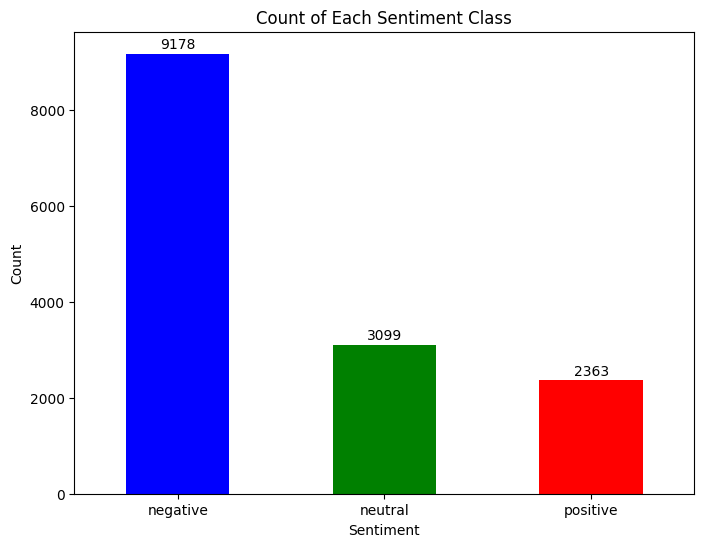

In [ ]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment Class')
plt.xticks(rotation=0)

# Adding count annotations on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.show()

- **Remarks**:
    -  The number of negative sentiment is equal to the number of non-null values for the feature 'negativereason'. It's good for further analysis
    -  The negative tweets are 3 and 4 times greater than its counterparts

## What are the leading reasons causing the negative sentiments?

In [ ]:
# Count genative reason
negative_reasons = df['negativereason'].value_counts().sort_values(ascending=False)
negative_reasons

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

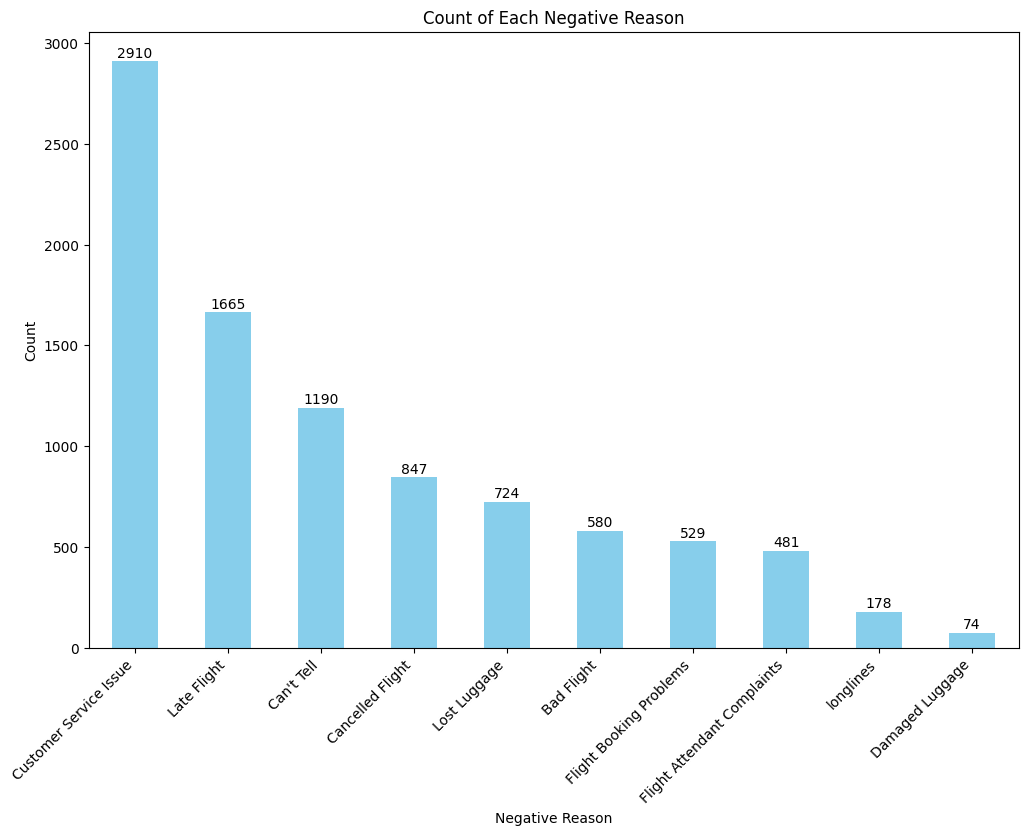

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
negative_reasons.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.title('Count of Each Negative Reason')
plt.xticks(rotation=45, ha='right')

# Adding count annotations on top of each bar
for i, count in enumerate(negative_reasons):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

- **Remarks**
    - The two biggest reasons for negative sentiments are Customer Service Issue and Late Flight, which account for 2910 and 1665 bad sentiment Tweets respectively
    - It is supprising that the Damaged Luggage reason is responsible for only 74 negative Tweet.
    - Based on these statistics the airway can find out the way to improve their services

## Similarly, find negative reasons for a specific airline

In [ ]:
# For example 'United' airway
# Count genative reason
negative_reasons_united = df[df['airline'] == 'United']['negativereason'].value_counts().sort_values(ascending=False)
negative_reasons_united

negativereason
Customer Service Issue         681
Late Flight                    525
Can't Tell                     379
Lost Luggage                   269
Bad Flight                     216
Cancelled Flight               181
Flight Attendant Complaints    168
Flight Booking Problems        144
longlines                       48
Damaged Luggage                 22
Name: count, dtype: int64

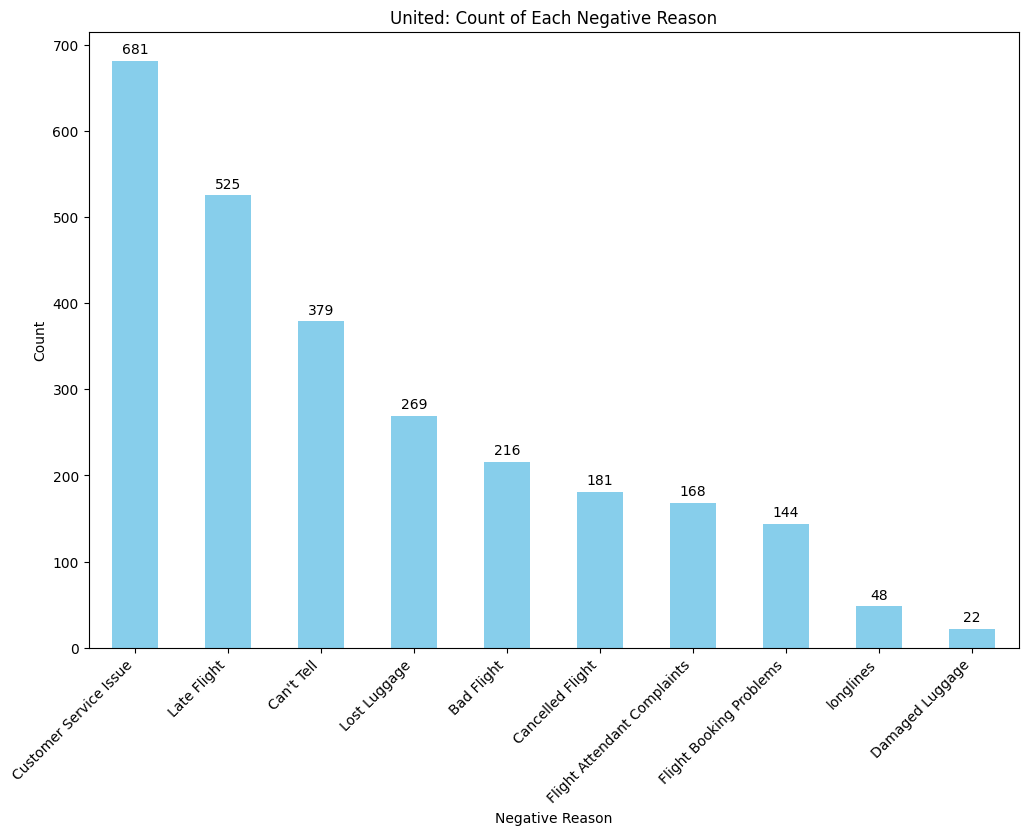

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
negative_reasons_united.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.title('United: Count of Each Negative Reason')
plt.xticks(rotation=45, ha='right')

# Adding count annotations on top of each bar
for i, count in enumerate(negative_reasons_united):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

## How was the flight by date

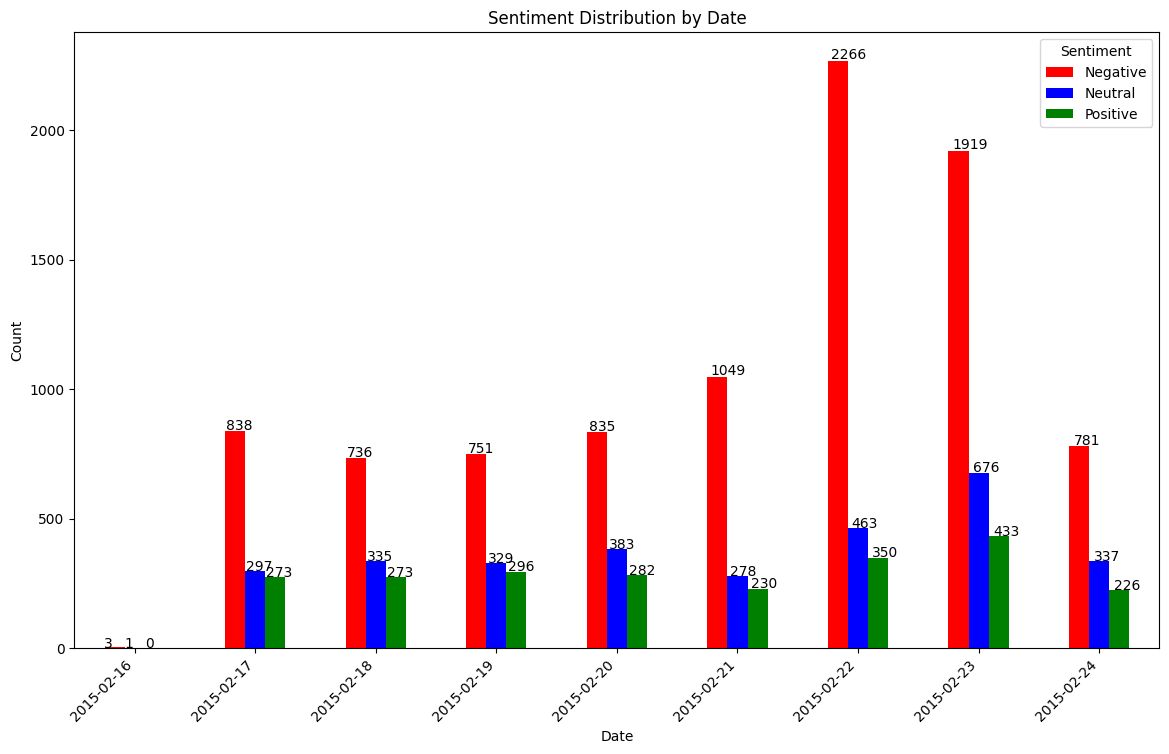

In [ ]:
# Extract the date from 'tweet_created'
df['date'] = df['tweet_created'].dt.date

# Group by date and sentiment and count the occurrences
sentiment_by_date = df.groupby(['date', 'airline_sentiment']).size().unstack(fill_value=0)

# Plotting the bar chart
ax = sentiment_by_date.plot(kind='bar', stacked=False, figsize=(14, 8), color=['red', 'blue', 'green'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Date')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=45, ha='right')

# Adding count annotations on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

- **Remarks**
    - The worst day for airways is 2015-02-22 with 2266 negative comments, followed by the next day with 1919 negative feedbacks
    - Everyday, the negative comments are always greater than its counterparts
    - The first date, 2015-02-16, has very little comments. It can be understandable as we looked at the earlier analysis: Earliest timestamp: 2015-02-16 23:36:05-08:00, that date, dataset started at **23h36**

# Conclusion
- Based on the above facts and analysis, it can be deduced that
    -  United, US Airways and American airways are the three worst airway
    -  Customer Service Issue and Flight Late are the two biggest reasons for negative flight experience
    -  February 22rd 2015 was the worst day for airway services
    -  Flight Customers tend to use Tweets to express their unconformtable sentiments